# Assignment 2 - CS110

## 1. Counting Bloom Filters - An Overview

**The problem:**

Let us aim for a data structure that supports the necessary operations to know whether a given element $e$ is in the set $A$. 

**The simplest, but inneficient, solution:**

The simplest way to achieve this would be through the use of a linear vector $v$ that stores each of the elements in $A$. The operation to check whether the element is in the set or not would consist in iterating $v$ and checking each of the positions in the vector. It is trivial that such operation would have a time complexity of $O(n)$.

**How to do a little bit better?**

We may do better if we store the elements in a hash table that allows us to access the elements (and hence check whether they exist or not) in $\Theta(1)$ time. But this would be a waste of space. We would be storing the elements even though we are only interested in checking whether they are in the set $A$ or not.

Instead, it would be more efficient to just record their "existence" in the set. In other words, to use only one bit of information to record either **$(1)$ if $e$ is in $A$**, or **$(0)$ if $e$ is *not* in $A$**. We would certainly start with a hash table filled with zeros, and would switch bits in the aproppriate cells to *one* after building the table (inserting the elements of $A$).

However, under this setting, collisions are devastating. We cannot possibly differentiate whether the $1$ already placed in a given cell corresponds to the existence of the element $e$ that a query is asking for (in addition, traditional approaches to handle collisions in hash tables would not be applicable). 

**How to, actually, do better? - *BLOOM FILTERS***

**We may use, then,** more than one hash function ($h_1,h_2,h_3...$) to place a $1$ in each of the different slots that the set of hash functions being used return for a given element $e$. Then, when querying for an element, it will be *unlikely* that all the slots returned by all the hashes for a given element $e_1$ as input, will be exactly the same as for another element $e_2$. This is the idea of a ***Bloom Filter***.

One may emphasize the use of the word *unlikely*. It is still, essentially, possible that two elements point toward the same exact slots. **In addition**, it is also quite (and more) possible that an element $e_1$ points toward slots that interfere with the ones of many other elements (not necessarily only the ones of $e_2$, but also either $e_3, e_4, ..., e_n$). When this happens, the query will equivocally return that the element exist - this is known as a **false positive**. The opposite, **false negatives**, cannot (trivially) occur because if an element was ever inserted, all the corresponding slots would have been switched to one after building the table.

The number of hash functions used is denoted by $k$. Depending on the value of $k$ and the number of elements $m$, the ratio of false positives will be more, or less, optimal.

So, even though we do not get rid entirely of the possibility of false positives, Bloom filters are certainly a step forward towards making such possibility more unlikely (compared to the possible approach described in the previous section). One may also note that if one actually chooses $k=1$, the Bloom filter is essentially equivalent to such approach in the previous section (but no one would ever certainly do that, unless we want to ruin the whole purpose of Bloom filters). 

#### **What about deletions..? - *COUNTING BLOOM FILTERS***

Traditional bloom filters cannot support the removal of items, because if we remove a $1$ (switch the respective bit to $0$) from a slot, it is likely that we will be affecting the slots of many other elements - allowing the possibility of later having several false negatives.

A way to resolve this is through the use of a ***Counting Bloom Filter***. In Counting Bloom Filters, there is a (n-bit) counter on each slot of the table, instead of just a single bit of information for representing either just $1$ or $0$. The counter goes up every time a value is inserted, and down every time a value is removed. For example, if we aim to remove element $e_1$, all counters of all the corresponding slots in the Counting Bloom Filter go down by one. Later, when we do a query for $e_1$, we would expect that it is *likely* that at least one of the corresponding slots for $e_1$ would have gone down to zero (but not necessarily all of them). If that is the (likely) case, the query returns negative, as we would expect. On the other hand, if that is not the case (because enough other elements were "inserted" in the same slots corresponding to $e_1$), the query would unfortunately return a false positive (not a negative, as it "should" have). 


## 2. Implementation of a Counting Bloom Filter

In [1]:
# Import the necessary libraries
import random
import string
import math


# IMPLEMENTATION OF COUNTING BLOOM FILTER    
    
# Empty hash table generator
def empty_hash_table(N):
    return [0 for n in range(N)]

# BLOOM FILTER GENERATOR
# p stands for false positive rate
# n stands for the number of items to store.
def empty_bloom_filter(p,n):
    
    
    # Calculate the corresponding memory size m
    m = - math.floor((n * math.log(p))/(math.log(2)**2))
    
    # Create the bloom filter based on this parameters
    bfilter_table = empty_hash_table(m)
    
    return bfilter_table
   
# Returns the required number of hash functions k based
# a given false positive ratio p
def required_k(p):
    # Calculate the required number of hash functions
    # for the desired p.
    k = (-1)* round(math.log(p,2))
    
    return k 

# Inserts an item bloom filter an item.
def add_to_bloom_filter(hash_table, item, hash_functions):
    N = len(hash_table)
    
    for i in range(len(hash_functions)):
        index = hash_functions[i](item) % N    
        hash_table[index] += 1
    
    return hash_table


def query(hash_table, item, hash_functions):
    N = len(hash_table)
    
    for i in range(len(hash_functions)):
        index = hash_functions[i](item) % N  
        
        if hash_table[index] == 0:
            return False
        
    return True
    
    # return true if the item has already been stored in the hash_table


def remove(hash_table, item, hash_functions):
    if not query(hash_table, item, hash_functions):
        raise ValueError()

    N = len(hash_table)
    
    for i in range(len(hash_functions)):
        index = hash_functions[i](item) % N
        if hash_table[index] != 0:
            hash_table[index] -= 1
    
    return hash_table


# IMPLEMENTATION OF HASH FUNCTIONS

# Produces a hash function based on a template by considering a template as a parameter
def make_hash_function(offset_size):
    
    # HASH FUNCTION TEMPLATE
    def hash_function(string):
        # If we need an offset for the input, we add it.
        # As we're dealing with strings, we'll just add "*"
        # as many times as necessary.
        for i in range(offset_size):
            string += "*"

        # Compute the hash code
        ans = 0
        for i in range(len(string)):
            ans = 31*ans + ord(string[i])
            
        return ans # Inpired in Hurner's Rule
        
    return hash_function

# Generates a list of "different" hash functions
def hash_functions_generator(k):
    
    hashes_list = []
    
    for offset_size_i in range(0,k):
        hash_func = make_hash_function(offset_size_i)
        hashes_list.append(hash_func)
        
    return hashes_list


# HELPER FUNCTIONS / UTILITIES

# Random Words Generator
def randomword(length):
    return ''.join(random.choice(string.ascii_lowercase) for i in range(length))

# List of random words generator
def randomwords_list(list_length, word_length):
    rword_list = []
    
    for i in range(list_length):
        rword = randomword(word_length)
        rword_list.append(rword)
        
    return rword_list


In [2]:
rword = randomword(11)

p = 0.1
n = 3

htable = empty_bloom_filter(0.1,3)

hashes_list = hash_functions_generator(4)
# hashes_list.append(hash_str1)
# hashes_list.append(hash_str2)
# hashes_list.append(hash_str3)
# hashes_list.append(hash_str4)
#print(hashes_list)

print("Given the desired false positive rate p: ", p)
print("Given the number of items to store n: ", n)
print("\nTable: ", htable)

print("\n...Adding x...")
add_to_bloom_filter(htable, "x", hashes_list)
print("...Adding y...")
add_to_bloom_filter(htable, "y", hashes_list)
print("...Adding z...\n")
add_to_bloom_filter(htable, "z", hashes_list)

print("\nTable: ", htable)


print("\nContains x?", query(htable, "z", hashes_list))
print("Contains y?", query(htable, "y", hashes_list))
print("Contains z?", query(htable, "z", hashes_list))

print("Contains a (An element that was never inserted) ?", query(htable, "a", hashes_list))



print("\n...Removing y...\n")
remove(htable, "y", hashes_list)
print("Table: ", htable)

print("\nContains x?", query(htable, "x", hashes_list))
print("Contains y?", query(htable, "y", hashes_list))
print("Contains z?", query(htable, "z", hashes_list))

print("\n...Removing x...\n")
remove(htable, "x", hashes_list)
print("Table: ", htable)
print("\nContains x?", query(htable, "x", hashes_list))
print("Contains y?", query(htable, "y", hashes_list))
print("Contains z?", query(htable, "z", hashes_list))

print("\n...Removing z...\n")
remove(htable, "z", hashes_list)
print("Table: ", htable)
print("\nContains x?", query(htable, "x", hashes_list))
print("Contains y?", query(htable, "y", hashes_list))
print("Contains z?", query(htable, "z", hashes_list))

print("\nTable: ", htable)






Given the desired false positive rate p:  0.1
Given the number of items to store n:  3

Table:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

...Adding x...
...Adding y...
...Adding z...


Table:  [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Contains x? True
Contains y? True
Contains z? True
Contains a (An element that was never inserted) ? False

...Removing y...

Table:  [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]

Contains x? True
Contains y? False
Contains z? True

...Removing x...

Table:  [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]

Contains x? False
Contains y? False
Contains z? True

...Removing z...

Table:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Contains x? False
Contains y? False
Contains z? False

Table:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3. Description of Implemented Hash Functions

In order to produce $k$ hash functions, a *hash_functions_generator* is used. This function, produces $k$ hash functions based on a single template of a hash function for strings (that will be described later). The key is that in order to produce $k$ different functions based on the template, the generator applies an increasing offset that affects the input of the template hash function prior to execute its core algorithm. To make each of these points clear, we will start by describing the template hash function and afterwards the *hash_functions_generator*. 

### Template Hash Function:

The function computes a polynomial whose coefficients are the ASCII integer values of the chars in the input string. In other words, given the polynomial

$$p(x) = \sum_{i=0}^{n} a_ix^i = a_0+a_1x+a_2x^2+...+a_nx^n$$

We define $a_i$ as the value corresponding to the $i_{th}$ char in the input string. $x$ is an arbitrary integer (for this implementation, $x=31$).

However, in order to make this polynomial feasable to compute, a new sequence of constants is defined as follows:

$$b_n:=a_n$$
$$b_{n-1}:=a_{n-1}+b_{n}x_0$$
$$.$$
$$.$$
$$.$$
$$b_{0}:=a_{0}+b_{1}x_0$$

**Where $b_0$ is then the value of $p(x_0)$.** This function is inspired in the algorithm for computing polynomials known as [Hurner's Rule](https://en.wikipedia.org/wiki/Horner%27s_method).

### Producing several hash functions from the template hash function 

Under the premise that by having a good hash function with a wide output, there will not be correlation between similar inputs of such a hash, one can use such hash function to generate multiple *different* hash functions by passking $k$ different initial values based on the original input. For example, if the input were numbers, for number $8$, we would pass $8,9,...,8+k-1$ to the hash function to simulate the output of many $k$ hash functions. In the case of strings, we may append a dummy value (e.g., "*"), that we will call an offset, $k-1$ times (which is what the generator in this implementation does). 

Here is the excerpt of the code that produces a different hash function, from a template, by considering an offset:


```python
# Produces a hash function based on a template by considering a template as a parameter
def make_hash_function(offset_size):
    
    # HASH FUNCTION TEMPLATE
    def hash_function(string):
        # If we need an offset for the input, we add it.
        # As we're dealing with strings, we'll just add "*"
        # as many times as necessary.
        for i in range(offset_size):
            string += "*"

        # Compute the hash code
        ans = 0
        for i in range(len(string)):
            ans = 31*ans + ord(string[i])
            
        return ans # Inpired in Hurner's Rule
        
    return hash_function
```

And here is the excerpt of the code that models the generator. It sends offsets of sizes $i=0$ to $i=k-1$ to the *make_hash_function* method and returns all the results in a python list

```python
# Generates a list of "different" hash functions
def hash_functions_generator(k):
    
    hashes_list = []
    
    for offset_size_i in range(0,k):
        hash_func = make_hash_function(offset_size_i)
        hashes_list.append(hash_func)
        
    return hashes_list
```

**Below is a demonstration that the different generated hash functions produce values that are *"disparate enough"* for $k=5$ and $input =$"$HelloWorld!$".** 

In [3]:
k = 5
hasheslist = hash_functions_generator(k)

for i in range(k):
    print(hasheslist[i]("HelloWorld!"))


61778823204871713
1915143519351023145
59369449099881717537
1840452922096333243689
57054040584986330554401


## 4. Scale of Growth of Different Variables 

### 4.1 Memory size as a function of the false positive rate

According to (Starobinski, Trachtenberg & Agarwal, 2003), the length of a Bloom filter $m$ ought to be approximately: 

$m=-\frac{n \ln p}{(ln2)^2}$

Thus, assumming a fixed $n$, the memory size $m$ of the Bloom filter grows proportionally to $\ln p$. 

Therefore, **we may attempt to describe the space complexity of a bloom filter as a function of $p$ with:**

#### $m_{(p)}=O(\ln p)$

**However**, by applying asymptotic notation to this problem, we miss the essential fact that as $p$ increases, $m$ decreases. Something that we must keep in mind, besides the fact that $0 \leq p \leq 1$. 

**Hence**, it is certainly **not accurate** to apply asymptotic notation to variables that are not explicitely defined as a function of $n$. For this reason, the fact to keep present is that $m$ **is inversely proportional to $p$**, or:
## $m \propto \frac{1}{p}$



### 4.2 Memory size as a function of the number of items stored

Recalling that according to (Starobinski et. al., 2003), the length of a Bloom filter $m$ is approximately: 

$m=-\frac{n \ln p}{(ln2)^2}$

We realize that for a *given* false positive rate (or probability) $p$, the length of a Bloom filter $m$ is proportionate to the number of items stored $n$.

**Therefore, the space complexity of $m$, as a function of the number of items stored $n$, is described by:** 

### $m_{(n)} = O(n)$

 
One may recall that the required number of hash functions $k$ directly depends on the target false positive rate $p$, which one chooses arbitrarily (given by $k=-\log_2 p$) (Starobinski et. al., 2003).


### 4.3 Access time as a function of the false positive rate

Because Bloom filters rely on hashes to insert and access the slots in the table, **the access time is described by $O(1)$.** 


In other words, access time is only **affected by $k$**, which is a constant, but **NOT** in proportion to the size of the bloom filter $m$, the number of items stored $n$, **or the false positive rate $p$.**

I.g., 
#### $Access\ Time_{(p)} = O(k) \rightarrow O(1)$.  

### 4.4 Access time as a function of the number of items stored

Under the same reasoning, because Bloom filters rely on hash functions to insert and access the slots in the table, **the access time is described by $O(1)$.** It is not affected by $n$.

I.g., 
#### $Access\ Time_{(n)} = O(k) \rightarrow O(1)$.  

## 5. Experimental evidence that implementation matches the theoretically expected rates

### 5.0 Evidence that false positive rate matches the theoretically expected rate.

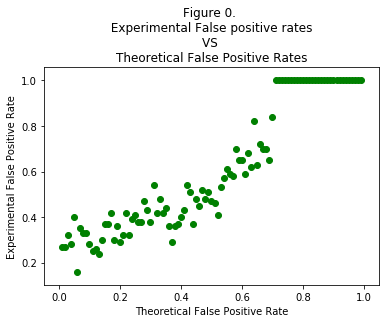

In [21]:
# Import the necessary libraries
import matplotlib.pyplot as plt

theoretical_rates = []
p_rates = []

n = 100



for p in range(1,100):
    
    theoretical_p_rate = p / 100 
    
    k = required_k(theoretical_p_rate)
    hashes_list = hash_functions_generator(k)
    
    # Bloom Filter Table
    bfilter = empty_bloom_filter(theoretical_p_rate, n)
    
    # Produce a list of random words of size n
    rwords_list = randomwords_list(n,11)
    
    # Insert elements
    for i in range(len(rword_list)):
        add_to_bloom_filter(bfilter, rword_list[i], hashes_list)
        
        
    
    # Produce a list of *****FALSE***** random words of size n
    # we assumme it is very unlikely that the generator will produce a word that was produced the for the real list of inserted elements.
    FALSE_rwords_list = randomwords_list(n,11)
    
    false_positive_count = 0
    
    # Query the list n times, seeking "false" words in the list.
    for i in range(len(FALSE_rwords_list)):
        
        # As we are seeking for "false" words, we know that if the query returns true, it will be a false positive.
        false_positive = query(bfilter, FALSE_rwords_list[i], hashes_list)
        
        if (false_positive):
            false_positive_count +=1
            
    
    false_positive_rate = false_positive_count / n
    
    # APPEND THE RESULTS OF THE EXPERIMENT
    theoretical_rates.append(theoretical_p_rate)
    p_rates.append(false_positive_rate)
    
    

    
    
# Time to plot the results.
plt.scatter(theoretical_rates,p_rates,c='g')
# Improve the layout of the graph
plt.title('Figure 0. \n Experimental False positive rates \nVS \nTheoretical False Positive Rates')
plt.xlabel('Theoretical False Positive Rate')
plt.ylabel('Experimental False Positive Rate')

plt.show()
   
    
    
    


**We can appreciate that up to a certain probability, the experimental rates approximately match the theoretical rates. After such point, the practical false positive rate gets close to 1, as the number of collisions in the table increases dramatically.**

### 5.1 Memory size as a function of the false positive rate

* We will fix $n$ at $100$ items

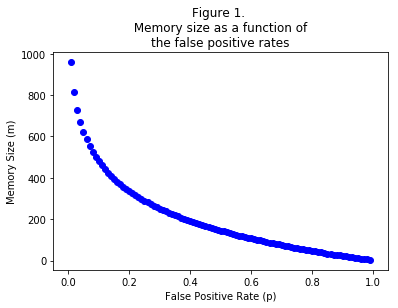

In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt

# False positive rates list
p_rates = []
# Memory size
m_sizes = []

# Items n
n = 100



for p in range (1,100): #from probability 1% to 100%
    # Produce a list of random words of size n
    rword_list = randomwords_list(n,11)
    
    # false positive rate
    p_rate = p / 100 # We need to use the value as a value frm 0 to 1
    
    # corresponding k
    k = required_k(p_rate)
    hashes_list = hash_functions_generator(k)
    
    # Bloom Filter Table
    bfilter = empty_bloom_filter(p_rate, n)
    
    # Insert elements - **not necessary**, as 
    # we are only interested in the size of the table m.
    # But we'll do it for the sake of full expliciteness...
    for i in range(len(rword_list)):
        add_to_bloom_filter(bfilter, rword_list[i], hashes_list)
        
        
    # Append the information and results of this experiment.
    m_sizes.append(len(bfilter))
    p_rates.append(p_rate)
    
    
# Time to plot the results.
plt.scatter(p_rates,m_sizes,c='b')
# Improve the layout of the graph
plt.title('Figure 1. \n Memory size as a function of \nthe false positive rates')
plt.xlabel('False Positive Rate (p)')
plt.ylabel('Memory Size (m)')

plt.show()
    

This result would match the theoretically expected rate of:

$m\approx-\frac{n \ln p}{(ln2)^2}\longrightarrow O(\ln p)$

**However**, one may note that the shape of the graph evidently goes downwards. This is because $\ln p$, for $0 \leq p \leq 1$, will yield a negative value, but the formula for the approximation of $m$ multiplies by $-1$, yielding a positive value so that as $p$ increases, $m$ decreases. Still, we may describe the space complexity in terms of $p$ as of being $O(\ln p)$, following the rules of asymptotic notation. The interpretation is that for sufficiently large $p$, the memory size $m$ will still necessarily lie below $f(p)=c_1*\ln p$. 

#### **Certainly**, this interpretation in terms of asymptotic notation is misleading and misses several properties that can be appreciated in the graph **(e.g., the lower $p$, the infinitely more memory space $m$ that will be needed)** - that are particularly relevant becuause the values that $p$ can take  are constrained to $0\leq p \leq1$. 

**Moral: asymptotic notation should not be used to describe variables that we do not intend to define as a function of $n$.**

In brief, as we previously suggested:

## $m \propto \frac{1}{p}$

This is intuitive, because the lower the false positive rate that we aim, the more space that will be needed to avoid "collisions" in the filter. On the other hand, the higher the allowed false positive rate, the less space that is needed because more "collisions" would be permitted.



### 5.2 Memory size as a function of the number of items stored

* We will assumme a desired false positive rate of $p=1\%$
* This yields a value of $k=-\frac{\ln p}{\ln 2}=-\log_2 p=-\log_2 0.1=3.32\approx3$

Then, the memory size (m) as a function of the number of items stored n varies as follows.

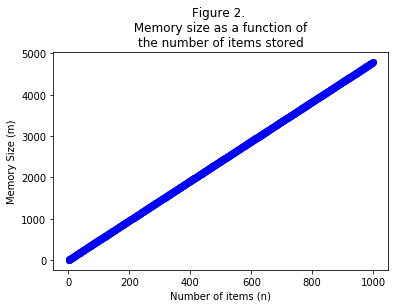

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Number of items stored n
n_sizes = []
# Memory size
m_sizes = []

# False positive rate p
p = 0.1
k = required_k(p) # yields k = 3

hashes_list = hash_functions_generator(k)



for n in range (1,1000): #from n = 1 to n = 1000
    # Produce a list of random words of size n
    rword_list = randomwords_list(n,11)
    
        
    # Bloom Filter Table
    bfilter = empty_bloom_filter(p, n)
    
    # Insert elements - **not necessary**, as 
    # we are only interested in the size of the table m.
    # But we'll do it for the sake of full expliciteness...
    for i in range(len(rword_list)):
        add_to_bloom_filter(bfilter, rword_list[i], hashes_list)
        
        
    # Append the information and results of this experiment.
    n_sizes.append(n)
    m_sizes.append(len(bfilter))
    
    
# Time to plot the results.
plt.scatter(n_sizes,m_sizes,c='b')
# Improve the layout of the graph
plt.title('Figure 2. \n Memory size as a function of \nthe number of items stored')
plt.xlabel('Number of items (n)')
plt.ylabel('Memory Size (m)')

plt.show()
    

This result matches the theoretically expected rate of:

$m\approx-\frac{n \ln p}{(ln2)^2}\longrightarrow O(n)$


### 5.3 Access time as a function of the false positive rate

* We will fix the number of items stored at $n=10000$.


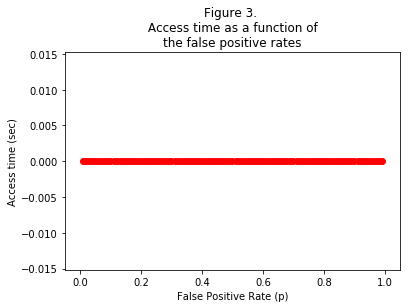

In [6]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt

# False positive rates list
p_rates = []
# Access times
all_access_times = []

# Items n
n = 10000



for p in range (1,100): #from probability 1% to 100%
    # Produce a list of random words of size n
    rword_list = randomwords_list(n,11)
    
    # false positive rate
    p_rate = p / 100 # We will use the value as a decimal
    
    # corresponding k
    k = required_k(p_rate)
    hashes_list = hash_functions_generator(k)
    
    # Bloom Filter Table
    bfilter = empty_bloom_filter(p_rate, n)
    
    # Insert elements
    for i in range(len(rword_list)):
        add_to_bloom_filter(bfilter, rword_list[i], hashes_list)
        
    # Track access time, by accessing all elements and taking the avg
    start_time = time.time()
    
    for i in range(len(rword_list)):
        query(bfilter,rword_list[i],hashes_list)
    
    total_time = time.time() - start_time
    
    # access_time stands for the time it takes to access any given element
    # under this circumnstances (i.g., m being of a particular size)
    access_time = total_time / n
    
    # Append the information and results of this experiment.
    p_rates.append(p_rate)
    all_access_times.append(access_time)
    
    
# Time to plot the results.
plt.scatter(p_rates,all_access_times,c='r')
# Improve the layout of the graph
plt.title('Figure 3. \n Access time as a function of \nthe false positive rates')
plt.xlabel('False Positive Rate (p)')
plt.ylabel('Access time (sec)')

plt.show()

This result matches the theoretically expected rate of:

$Access\ Time_{(p)}=O(k)\rightarrow O(1)$

### 5.4 Access time as a function of the number of items stored

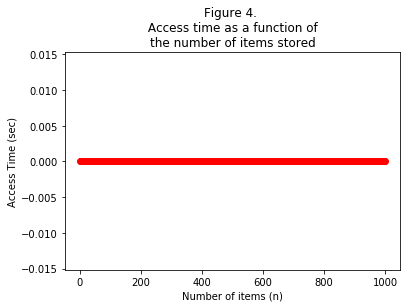

In [7]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt

# Number of items stored
n_items = []
# Access times
all_access_times = []

# Hash functions to be used
p = 0.1
k = required_k(p)
hashes_list = hash_functions_generator(k)

# Track the access times for the interval m [1,1000]

for n in range(1,1000):
    #Produce a list of random words of size n
    rword_list = randomwords_list(n,11)
    
    # Bloom Filter Table
    bfilter_table = empty_bloom_filter(p,n)
    
    # Insert elements
    for i in range(len(rword_list)):
        add_to_bloom_filter(bfilter_table, rword_list[i], hashes_list)
        
    # Track access time, by accessing all elements and taking the avg
    start_time = time.time()
    
    # ACCESS STUFF!!!!!!!
    for i in range(len(rword_list)):
        query(bfilter,rword_list[i],hashes_list)
    
    total_time = time.time() - start_time
    
    # access_time stands for the time it takes to access any given element
    # under this circumnstances (i.g., m being of a particular size)
    access_time = total_time / n
    
    # Append the information and results of this experiment
    n_items.append(n)
    all_access_times.append(access_time)
        

        
# Time to plot the results.
plt.scatter(n_items,all_access_times,c='r')
# Improve the layout of the graph
plt.title('Figure 4. \n Access time as a function of \nthe number of items stored')
plt.xlabel('Number of items (n)')
plt.ylabel('Access Time (sec)')

plt.show()

This result matches the theoretically expected rate of:

$Access\ Time_{(n)}=O(k)\rightarrow O(1)$

## Appendix

1. **#algorithms:** Creatively devised an algorithmic strategy, that eased the implementation of a counting bloom filter, by implementing a *hash_functions_generator* - demonstrating ability to write computer code for solving problems quickly and effectively.

## References

 1. Starobinski, D., Trachtenberg, A., Agarwal, S. (2003). "Efficient PDA Synchronization", IEEE Transactions on Mobile Computing, vol. 2, no. 01, pp. 40-51
 
 2. University of California, San Diego. Hash Functions for Strings. Retrieved from http://cseweb.ucsd.edu/~kube/cls/100/Lectures/lec16/lec16-14.html